Here we will try to simulate 3 qubit and 4 qubit interactions with only single and two qubit interactions

We only need the interactions to simulate
$\sigma_{z}\otimes \sigma_{z}\otimes \sigma_{z}$, $\sigma_{z}\otimes \sigma_{z}\otimes \sigma_{x}$ and $\sigma_{z}\otimes \sigma_{z}\otimes \sigma_{z}\otimes \sigma_{x}$.


Out of these the 2nd one is included in the hamiltonian of toffoli so no need to do that so only $1^{st}$ and $3^{rd}$ have to be done.

In [1]:
from pennylane import numpy as np
import pennylane as qml
from matplotlib import pyplot as plt
import skquant.opt as skqopt #optimization routines
from scipy.linalg import expm

In [18]:
I = np.eye(2)
X = np.array([[0, 1], [1, 0]])
Z = np.array([[1, 0], [0, -1]])
Y = np.array([[0,-1j],[1j, 0]])
dev1 = qml.device('default.qubit', wires=3)

# Hamiltonian for Toffoli
def hamiltonian_matrix1():
    H=np.pi/16*np.kron(np.kron(Z,Z),Z) 
    
    return expm(-1j*H)

In [19]:
U=hamiltonian_matrix1()

In [153]:

#@qml.qnode(dev)
def ansatz(params):
    l=params
    
    #H=I⊗I⊗Z
    qml.RZ(l[0],wires=2)
    
    #H=Z⊗I⊗Z
    qml.CNOT(wires=[0,2])
    qml.RZ(l[1],wires=2)
    qml.CNOT(wires=[0,2])
    
    # circuit for local ham H=I⊗Z⊗Z
    qml.CNOT(wires=[1,2])
    qml.RZ(l[2],wires=2)
    qml.CNOT(wires=[1,2])
    
    # circuit for local ham H=X⊗X⊗I  
    [qml.Hadamard(wires=i) for i in range(0,2)]
    qml.CNOT(wires=[0,1])
    qml.RZ(l[3],wires=1)
    qml.CNOT(wires=[0,1])
    [qml.Hadamard(wires=i) for i in range(0,2)]
    

     # circuit for local ham H=Y⊗Y⊗I
    [qml.RX(np.pi/2,wires=i) for i in range(0,2)]
    qml.CNOT(wires=[0,1])
    qml.RZ(l[4],wires=1)
    qml.CNOT(wires=[0,1])
    [qml.RX(-np.pi/2,wires=i) for i in range(0,2)]

    
    #H=Z⊗Z⊗I
    qml.CNOT(wires=[0,1])
    qml.RZ(l[5],wires=1)
    qml.CNOT(wires=[0,1])

    #Z⊗I⊗I
    qml.RZ(l[6],wires=0)
   
    #I⊗Z⊗I
    qml.RZ(l[7],wires=1)
    
    #I⊗I⊗X
    qml.RX(l[8],wires=2)
    
    #I⊗X⊗I
    qml.RX(l[9],wires=1)
    
    #X⊗I⊗I
    qml.RX(l[10],wires=0)
    
    # circuit for local ham H=X⊗I⊗X
    qml.Hadamard(wires=0)
    qml.Hadamard(wires=2)
    qml.CNOT(wires=[0,2])
    qml.RZ(l[11],wires=2)
    qml.CNOT(wires=[0,2])
    qml.Hadamard(wires=0)
    qml.Hadamard(wires=2)
    
    # circuit for local ham H=I⊗X⊗X
    [qml.Hadamard(wires=i) for i in range(1,3)]
    qml.CNOT(wires=[1,2])
    qml.RZ(l[12],wires=2)
    qml.CNOT(wires=[1,2])
    [qml.Hadamard(wires=i) for i in range(1,3)]
    
    
    qml.Hadamard(wires=2)
    qml.IsingZZ(l[13],wires=[0,2])
    qml.Hadamard(wires=2)
    
    qml.Hadamard(wires=2)
    qml.IsingZZ(l[14],wires=[1,2])
    qml.Hadamard(wires=2)
    
    

In [154]:
trotter_steps=5

In [155]:
@qml.qnode(dev1)
def circuit(params, state, apply_inv=True):
    qml.BasisState(np.array(state), wires=[0,1,2])
    
    for steps in range(trotter_steps):
        ansatz(params[:15])

    return qml.state()

def var_circ(params,state):
    result=(np.exp(-1j*params[0])*circuit(params[1:],state))
    
    return result

In [156]:
def get_unitary(params):
    return np.array([var_circ(params, state) for state in state_vector]).T

In [157]:
# 2nd cost the trace distance between two unitaries is taken as cost
def cost1(params):
    U_par=get_unitary(params)
    F=np.abs(np.trace(np.dot(np.transpose(np.conj(U_par)),U)))/len(U)
    
    return 1-F

In [160]:
params = np.random.random(16)
Id = np.eye(8, requires_grad=False)
state_vector=np.array([[0,0,0],[0,0,1],[0,1,0],[0,1,1],[1,0,0],[1,0,1],[1,1,0],[1,1,1]])
print(Id[7])
print(state_vector[7])

[0. 0. 0. 0. 0. 0. 0. 1.]
[1 1 1]


In [161]:
cost1(params)

0.6792234704304182

In [162]:
cost_arr=[]
params_arr=[]
F_nat=[]

In [163]:

def optimization2(params,st):
    dev = qml.device("default.qubit.autograd", wires=3)

    opt = qml.AdagradOptimizer(stepsize=st)
    
    
    for i in range(100+1):
        params = opt.step(cost1, params)

        if i % 10 == 0:
            print(f"Cost at step {i}:", cost1(params))
            cost_arr.append(cost1(params))
            params_arr.append(params)
            print(f"fidelity of natural dynamics with actual toffoli{i}:",Fidelity(hamiltonian_matrix(params*trotter_steps/2),U))

            
    if cost1(params)>0.008:
        params=np.random.random(16)
    if Fidelity(hamiltonian_matrix(params*trotter_steps/2),U)<0.99:
        st=np.random.uniform(0.01,0.2)
        optimization2(params,st)
        
            
    return params,st
        

In [164]:
optimization2(params,0.1) # st=learning rate==stepsize

Cost at step 0: 0.48685916581483224
fidelity of natural dynamics with actual toffoli0: 0.47847817622510685
Cost at step 10: 0.010270344020374744
fidelity of natural dynamics with actual toffoli10: 0.9873416746283562
Cost at step 20: 0.0030885533287909883
fidelity of natural dynamics with actual toffoli20: 0.9957830499617298
Cost at step 30: 0.002679598802490024
fidelity of natural dynamics with actual toffoli30: 0.9966271086214812
Cost at step 40: 0.0025058855196335994
fidelity of natural dynamics with actual toffoli40: 0.9969721284630432
Cost at step 50: 0.0024726313835371494
fidelity of natural dynamics with actual toffoli50: 0.9970708472764683
Cost at step 60: 0.0024683218923451378
fidelity of natural dynamics with actual toffoli60: 0.9971006746861115
Cost at step 70: 0.0024676345557358426
fidelity of natural dynamics with actual toffoli70: 0.9971116704027502
Cost at step 80: 0.002467434379385347
fidelity of natural dynamics with actual toffoli80: 0.9971161032168214
Cost at step 90:

(tensor([ 9.75726703e-01,  1.18268560e+00,  2.38159426e-03,
          2.35496923e-03,  5.34503399e-01,  5.34503425e-01,
          3.17137244e-14,  2.80583955e-01,  9.76053106e-01,
         -9.03668552e-03,  2.76518536e-10, -4.59551777e-15,
          1.49216014e-12,  8.53948007e-11,  3.12845485e-01,
          3.12853356e-01], requires_grad=True),
 0.1)

In [169]:
params_arr[len(params_arr)-1]

tensor([ 9.75726703e-01,  1.18268560e+00,  2.38159426e-03,
         2.35496923e-03,  5.34503399e-01,  5.34503425e-01,
         3.17137244e-14,  2.80583955e-01,  9.76053106e-01,
        -9.03668552e-03,  2.76518536e-10, -4.59551777e-15,
         1.49216014e-12,  8.53948007e-11,  3.12845485e-01,
         3.12853356e-01], requires_grad=True)

In [166]:
params_arr[len(params_arr)-1]*trotter_steps/2

tensor([ 2.43931676e+00,  2.95671401e+00,  5.95398565e-03,
         5.88742308e-03,  1.33625850e+00,  1.33625856e+00,
         7.92843111e-14,  7.01459888e-01,  2.44013277e+00,
        -2.25917138e-02,  6.91296341e-10, -1.14887944e-14,
         3.73040034e-12,  2.13487002e-10,  7.82113712e-01,
         7.82133391e-01], requires_grad=True)

In [158]:
I = np.eye(2)
X = np.array([[0, 1], [1, 0]])
Z = np.array([[1, 0], [0, -1]])
Y = np.array([[0,-1j],[1j, 0]])
dev = qml.device('default.qubit', wires=3)

# Hamiltonian for Toffoli
def hamiltonian_matrix(params):
    l=params
    H=l[0]*np.kron(np.kron(I,I),I) + l[1]*np.kron(np.kron(I,I),Z) + l[2]*np.kron(np.kron(Z,I),Z) + \
        l[3]*np.kron(np.kron(I,Z),Z) + l[4]*np.kron(np.kron(X,X),I) +\
        l[5]*np.kron(np.kron(Y,Y),I) + l[6]*np.kron(np.kron(Z,Z),I) + l[7]*np.kron(np.kron(Z,I),I) + \
        l[8]*np.kron(np.kron(I,Z),I) + l[9]*np.kron(np.kron(I,I),X) + \
        l[10]*np.kron(np.kron(I,X),I) + l[11]*np.kron(np.kron(X,I),I) + l[12]*np.kron(np.kron(X,I),X) + \
       l[13]*np.kron(np.kron(I,X),X) + l[14]*np.kron(np.kron(Z,I),X) + l[15]*np.kron(np.kron(I,Z),X) #+ \
#       l[16]*np.kron(np.kron(Y,I),I) + l[17]*np.kron(np.kron(I,Y),I) + l[18]*np.kron(np.kron(I,I),Y)
    
    return expm(-1j*H)


In [159]:
# Function to find the fidelity between two unitaries
def Fidelity(rho1,rho2):
    if rho1.shape!=rho2.shape:
        raise ValueError("Dimension of both matrices must be same")
    return (np.abs(np.trace(np.dot(np.transpose(np.conj(rho1)),rho2)))/len(rho1))

In [167]:
Fidelity(hamiltonian_matrix(params_arr[len(params_arr)-1]*trotter_steps/2),U)

0.9971188025009416

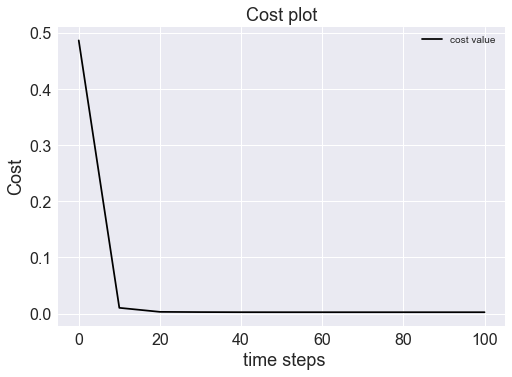

In [182]:
x=np.linspace(0,100,len(cost_arr))
y=cost_arr
plt.style.use("seaborn")
plt.plot(x,y,"black",label="cost value")
plt.title("Cost plot", fontsize=18)
plt.ylabel("Cost", fontsize=18)
plt.xlabel(" time steps", fontsize=18)
plt.tick_params(axis="both", which="major", labelsize=16)   # helps to increase the size of the values in X and Y axis
plt.tick_params(axis="both", which="minor", labelsize=16)
plt.legend()
plt.show()

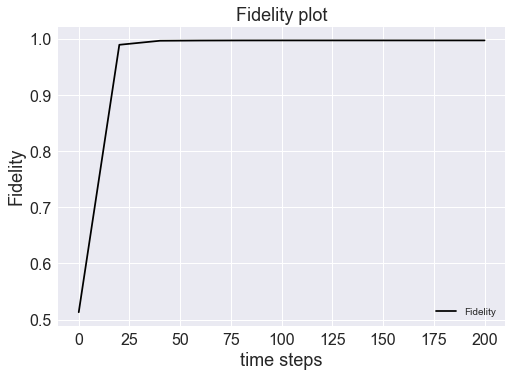

In [183]:
fidelity=[]
for elements in cost_arr:
    fidelity.append(1-elements)
    
fidelity
x=np.linspace(0,200,len(cost_arr))
y=fidelity
plt.plot(x,y,"black",label="Fidelity")
plt.title("Fidelity plot", fontsize=18)
plt.ylabel("Fidelity", fontsize=18)
plt.xlabel("time steps", fontsize=18)
plt.tick_params(axis="both", which="major", labelsize=16)   # helps to increase the size of the values in X and Y axis
plt.tick_params(axis="both", which="minor", labelsize=16)
plt.legend()
plt.show()

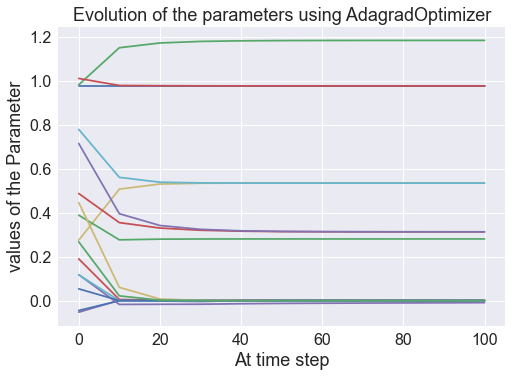

In [172]:
x=np.linspace(0,100,len(cost_arr))
y=params_arr
plt.plot(x,y)
plt.ylabel("values of the Parameter", fontsize=18)
plt.xlabel("At time step", fontsize=18)
plt.title("Evolution of the parameters using AdagradOptimizer", fontsize=18)
plt.tick_params(axis="both", which="major", labelsize=16)   # helps to increase the size of the values in X and Y axis
plt.tick_params(axis="both", which="minor", labelsize=16)
plt.legend()
plt.show()

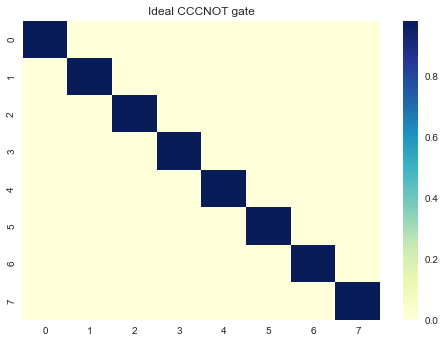

In [178]:
import seaborn
seaborn.heatmap(np.real(U),cmap="YlGnBu")
plt.title("Ideal CCCNOT gate")
plt.show()

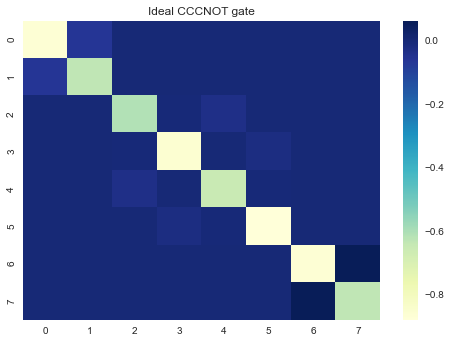

In [184]:
import seaborn
seaborn.heatmap(np.real(hamiltonian_matrix(params_arr[len(params_arr)-1]*trotter_steps/2)),cmap="YlGnBu")
plt.title("Ideal CCCNOT gate")
plt.show()